# Bird Species Classification over 500 bird species

### Classifying 500 bird species using CNN architecutre

### Notebook is under development it is a part of my MLOps project
Check my GitHub: https://github.com/karan842/bird-species-classification

## Importing libraries

In [6]:
# Classic data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
from sklearn.model_selection import train_test_split

# tensorflow libaries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import tqdm
import warnings
import glob
import os

# Metrics
from sklearn import metrics
import itertools

# WANDB 
import wandb
wandb.login()

# Noteboook setting
%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

wandb: Currently logged in as: karan842. Use `wandb login --relogin` to force relogin


## Load and transform data

In [13]:
dataset = '/kaggle/input/100-bird-species/train/'

In [18]:
species_types=os.listdir(dataset)
species_types

['DALMATIAN PELICAN',
 'WATTLED CURASSOW',
 'AMERICAN WIGEON',
 'CARMINE BEE-EATER',
 'GAMBELS QUAIL',
 'UMBRELLA BIRD',
 'AMERICAN KESTREL',
 'AMERICAN GOLDFINCH',
 'BLUE GROSBEAK',
 'PALM NUT VULTURE',
 'DUSKY LORY',
 'AUCKLAND SHAQ',
 'BLACK THROATED WARBLER',
 'YELLOW CACIQUE',
 'STRIPPED SWALLOW',
 'VERMILION FLYCATHER',
 'CAPE MAY WARBLER',
 'RED TAILED HAWK',
 'GURNEYS PITTA',
 'INDIAN ROLLER',
 'SNOW GOOSE',
 'GREEN WINGED DOVE',
 'AZURE TANAGER',
 'GREEN MAGPIE',
 'BANDED BROADBILL',
 'AFRICAN PYGMY GOOSE',
 'INDIGO FLYCATCHER',
 'GREY PLOVER',
 'TOUCHAN',
 'HYACINTH MACAW',
 'HARLEQUIN DUCK',
 'ABYSSINIAN GROUND HORNBILL',
 'CALIFORNIA QUAIL',
 'BALD IBIS',
 'WOOD THRUSH',
 'RUBY THROATED HUMMINGBIRD',
 'INDIGO BUNTING',
 'ALBERTS TOWHEE',
 'SORA',
 'HOODED MERGANSER',
 'ROSEATE SPOONBILL',
 'CAPE ROCK THRUSH',
 'BLUE COAU',
 'CALIFORNIA CONDOR',
 'BORNEAN PHEASANT',
 'BARN SWALLOW',
 'TAIWAN MAGPIE',
 'SPLENDID WREN',
 'RED BILLED TROPICBIRD',
 'BLACK THROATED BUSHTIT',
 'CH

## Placing data into a DataFrame

In [21]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

# print(labels)

In [23]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels,name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels],axis=1)
image_df

Filepath              Label
0      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
1      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
2      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
3      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
4      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
...                                                  ...                ...
80080  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80081  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80082  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80083  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80084  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE

[80085 rows x 2 columns]

## Exploratory Data Analyis

In [27]:
image_df['Label'].value_counts(ascending=False)

HOUSE FINCH                248
OVENBIRD                   233
D-ARNAUDS BARBET           233
SWINHOES PHEASANT          217
WOOD DUCK                  214
                          ... 
AMETHYST WOODSTAR          131
MASKED LAPWING             131
PATAGONIAN SIERRA FINCH    130
RED TAILED THRUSH          130
SNOWY PLOVER               130
Name: Label, Length: 500, dtype: int64

- Count of each class is ranging between 248 to 130

## Visualizing sample images from dataset

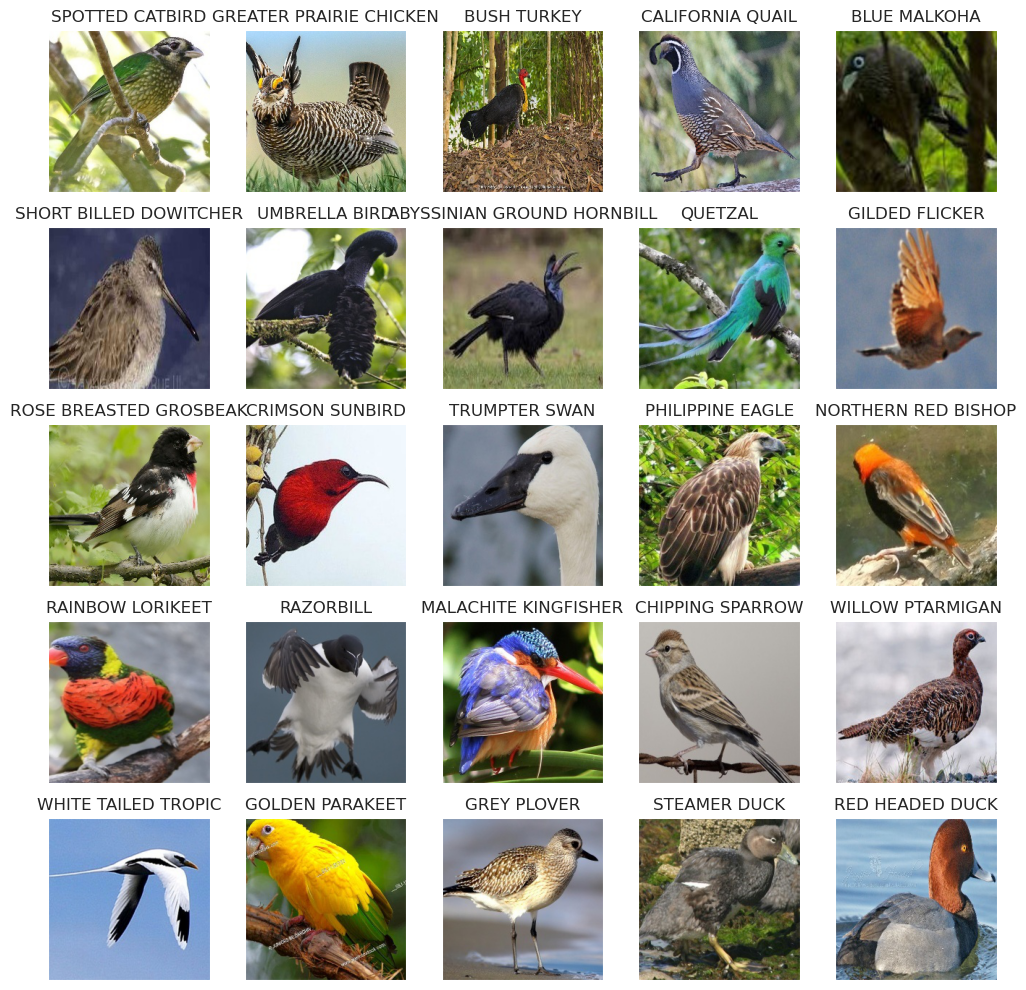

In [36]:
random_index = np.random.randint(0,len(image_df),25)
fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10),
                        subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show();

## Data Preprocssing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [37]:
# Seperate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2,
                                     shuffle=True,random_state=42)

### Data Augmentation 

In [58]:
# train_gen = ImageDataGenerator(
#     rotation_range = 15,
#     width_shift_range = 0.05,
#     height_shift_range = 0.05,
#     rescale = 1./255,
#     shear_range = 0.05,
#     brightness_range = [0.1,1.5],
#     horizontal_flip = True,
#     vertical_flip = True
# )

train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [59]:
# Split the data into three categories
train_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 51255 validated image filenames belonging to 500 classes.
Found 12813 validated image filenames belonging to 500 classes.
Found 16017 validated image filenames belonging to 500 classes.


In [60]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

## Training the model

In [62]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable=False

In [63]:
inputs = base_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(500,activation='softmax')(x)

model =  Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Weights and Biases configuration

In [64]:
# Run 
from wandb.keras import WandbCallback
run = wandb.init(project='birds-species-classification',
                config={ # include hyperparameters and metadata
                    "learning_rate":0.001,
                    "epochs":100,
                    "batch_size":32,
                    "es_patience":5,
                    "loss_function":"categorical_crossentropy",
                    
                })
config = wandb.config # we will use this to configure our experiment
tf.keras.backend.clear_session()

# model callbacks, optimizers and compilation

## Optimizer
optimizer = tf.keras.optimizers.Adam(config.learning_rate)

## Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=config.es_patience,
                              restore_best_weights=True)
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Model compile
model.compile(optimizer,config.loss_function,metrics=['accuracy'])

In [65]:
history = model.fit(
    train_images, 
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=config.epochs,
    callbacks=[
        early_stopping,
        WandbCallback(),
        checkpoint_callback,
    ]
)

Epoch 1/100
1602/1602 [==============================] - 613s 377ms/step - loss: 2.6266 - accuracy: 0.3990 - val_loss: 1.2291 - val_accuracy: 0.6774 - _timestamp: 1676976006.0000 - _runtime: 632.0000
Epoch 2/100
1602/1602 [==============================] - 195s 122ms/step - loss: 1.3315 - accuracy: 0.6424 - val_loss: 0.9941 - val_accuracy: 0.7395 - _timestamp: 1676976201.0000 - _runtime: 827.0000
Epoch 3/100
1602/1602 [==============================] - 188s 117ms/step - loss: 1.0717 - accuracy: 0.7026 - val_loss: 0.9127 - val_accuracy: 0.7580 - _timestamp: 1676976389.0000 - _runtime: 1015.0000
Epoch 4/100
1602/1602 [==============================] - 188s 118ms/step - loss: 0.9259 - accuracy: 0.7407 - val_loss: 0.8529 - val_accuracy: 0.7747 - _timestamp: 1676976590.0000 - _runtime: 1216.0000
Epoch 5/100
1602/1602 [==============================] - 192s 120ms/step - loss: 0.8323 - accuracy: 0.7626 - val_loss: 0.8615 - val_accuracy: 0.7798 - _timestamp: 1676976783.0000 - _runtime: 1409.00

# Model Evaluation

In [68]:
results = model.evaluate(test_images)
print("    Test Loss: {:.5f}%".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1]*100))

501/501 [==============================] - 47s 94ms/step - loss: 0.8639 - accuracy: 0.7775
    Test Loss: 0.86395%
Test Accuracy: 77.75%


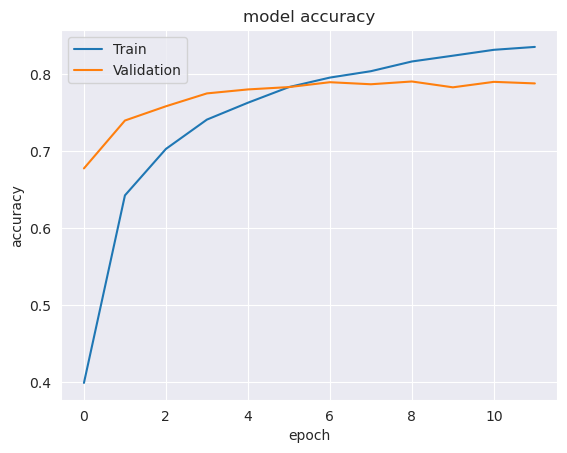

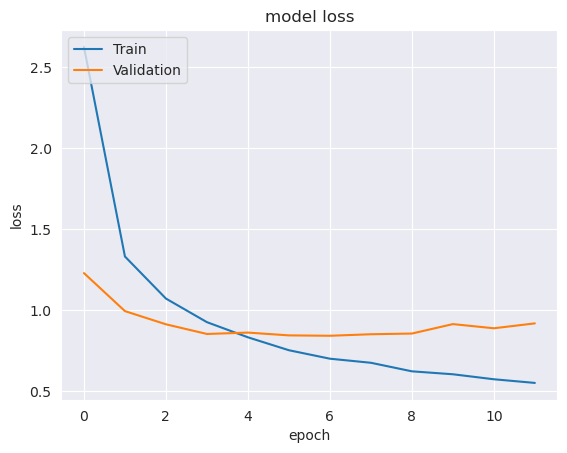

In [69]:
def plot_loss_accuracy_curves(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show();
    
plot_loss_accuracy_curves(history)

## Making predictiong on the test data

Predict the label of test_images

In [71]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
pred

501/501 [==============================] - 46s 92ms/step


array([185, 258, 312, ..., 283, 139, 466])

In [75]:
# train_images.class_indices

Map the label

In [76]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Result
print(f'First 5 predictions: {pred[:5]}')

First 5 predictions: ['DOUBLE EYED FIG PARROT', 'GREY HEADED FISH EAGLE', 'LARK BUNTING', 'CLARKS NUTCRACKER', 'CAMPO FLICKER']


### Display 25 Random images from dataset with their labels and predict with the model

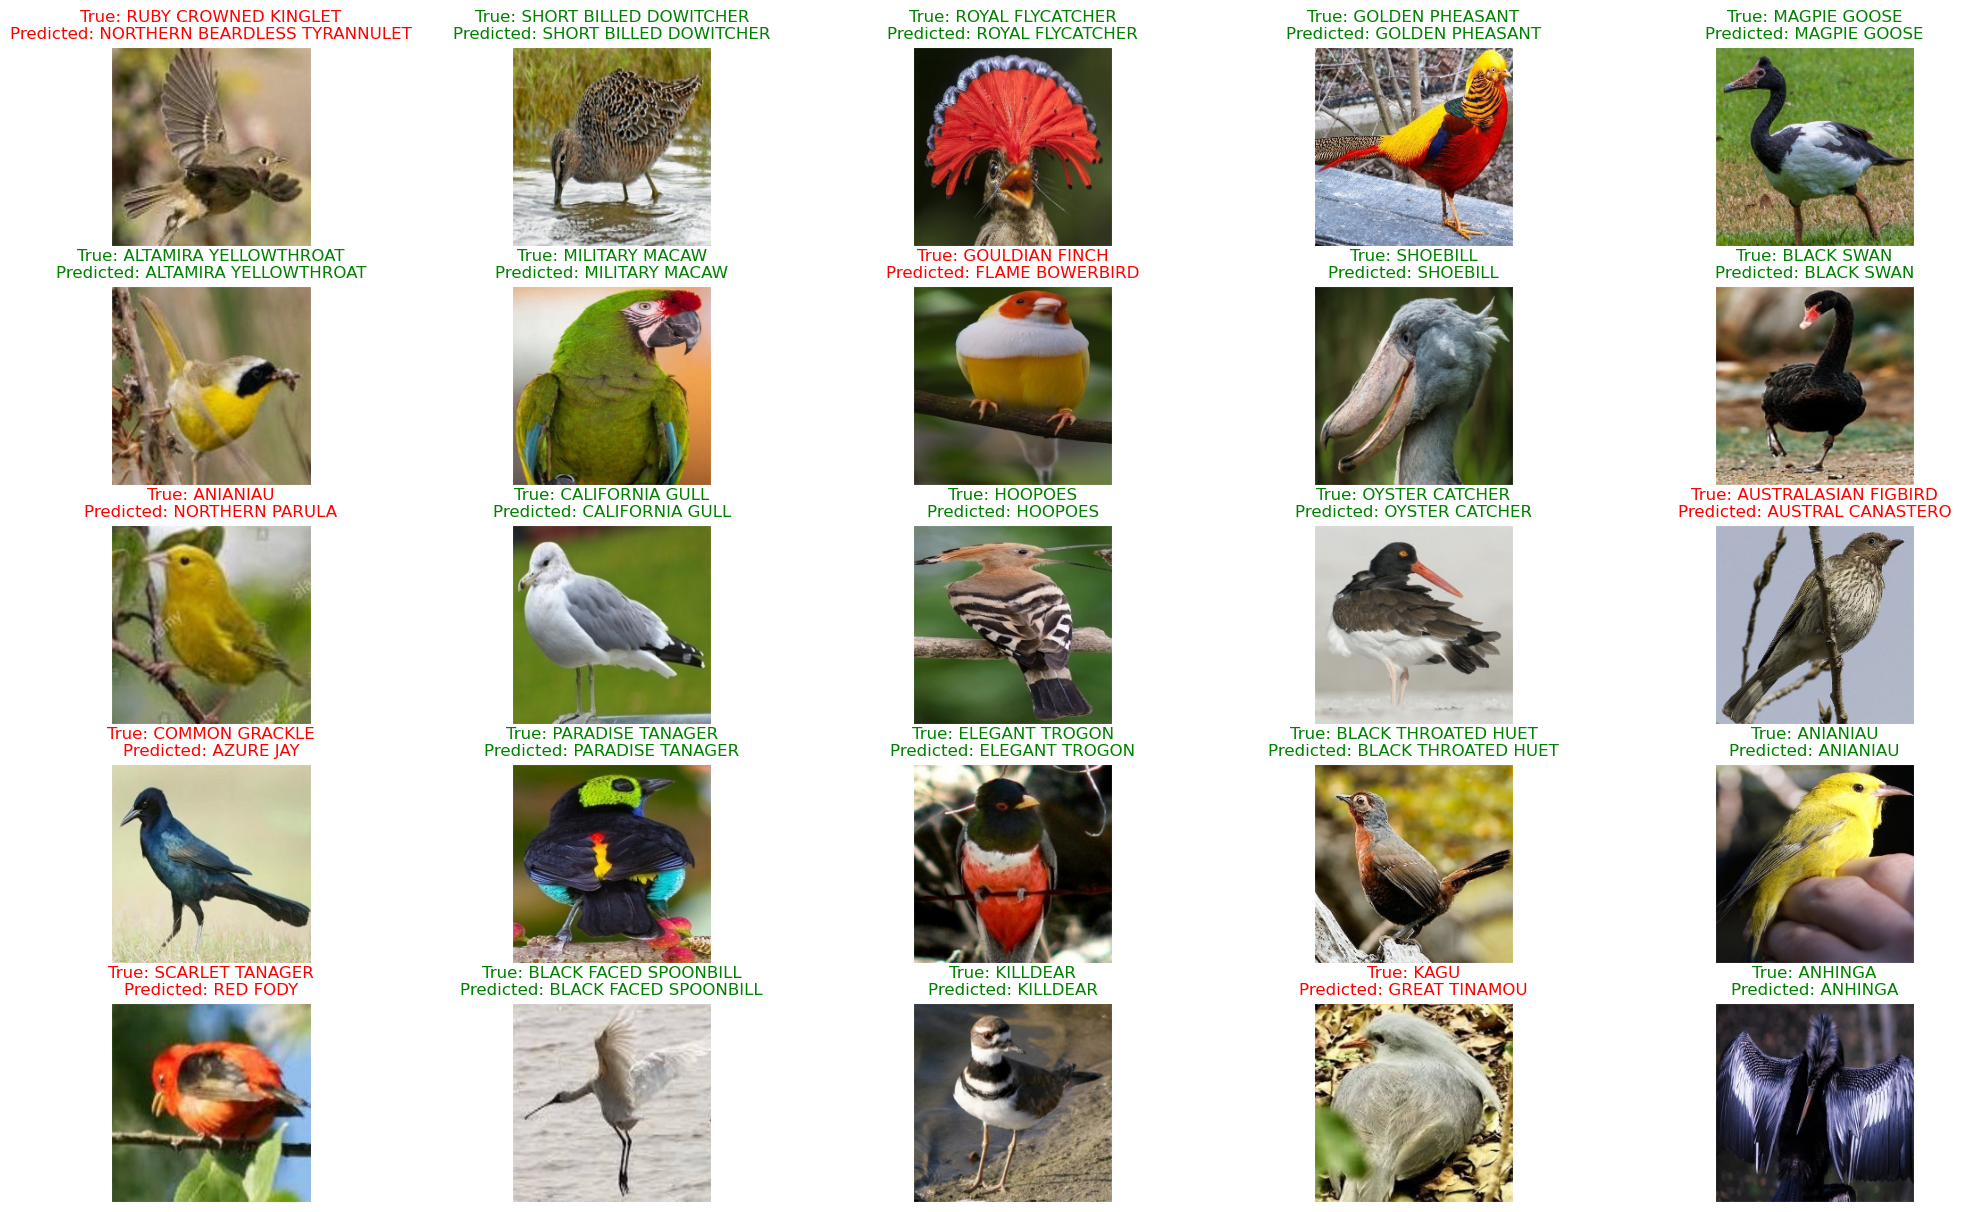

<Figure size 640x480 with 0 Axes>

In [78]:
random_index = np.random.randint(0,len(test_df)-1,25)
fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(25,15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}",
                color=color)

plt.show()
plt.tight_layout()

## Classification Report
We will convert our classification report into dataframe and find the best and worst classes using pandas operations for ease.

In [93]:
species = test_images.class_indices

In [97]:
y_test = list(test_df.Label)
report = metrics.classification_report(y_test, pred,target_names=species,output_dict=True)

data = []
for k,v in report.items():
    if k in species:
        data.append({'species':k,
                    'precision': v['precision'],
                    'recall': v['recall'],
                    'f1-score': v['f1-score'],
                    'support': v['support']})
df = pd.DataFrame(data)
df

species  precision    recall  f1-score  support
0                ABBOTTS BABBLER   0.666667  0.387097  0.489796       31
1                  ABBOTTS BOOBY   0.625000  0.294118  0.400000       34
2     ABYSSINIAN GROUND HORNBILL   0.785714  0.868421  0.825000       38
3          AFRICAN CROWNED CRANE   0.692308  1.000000  0.818182       18
4         AFRICAN EMERALD CUCKOO   0.621622  0.696970  0.657143       33
..                           ...        ...       ...       ...      ...
495                  WOOD THRUSH   0.508772  0.828571  0.630435       35
496                      WRENTIT   0.742857  0.666667  0.702703       39
497  YELLOW BELLIED FLOWERPECKER   0.472727  0.722222  0.571429       36
498               YELLOW CACIQUE   0.904762  0.791667  0.844444       24
499      YELLOW HEADED BLACKBIRD   0.916667  0.687500  0.785714       32

[500 rows x 5 columns]

### Lets see which TOP-10 classes has good and bad Precision/Recall/F1-Scores
F1-Score is a harmonic mean between **Precision and Recall**(trade-off). So, we will classes based on f1-score   

In [111]:
def best_classes(df):
    print("Classed with good result: ")
    top_10_good = df.nlargest(10,'f1-score')
    res = top_10_good[['species','precision','recall','f1-score','support']]
    return res
    
best_classes(df)

Classed with good result: 


species  precision    recall  f1-score  support
329            MANDRIN DUCK   1.000000  1.000000  1.000000       30
17        AMERICAN FLAMINGO   1.000000  0.969697  0.984615       33
306                  KAKAPO   1.000000  0.969697  0.984615       33
310                    KIWI   1.000000  0.967742  0.983607       31
461                 TOUCHAN   0.966667  1.000000  0.983051       29
370                 PEACOCK   0.961538  1.000000  0.980392       25
85   BLACK-CAPPED CHICKADEE   1.000000  0.954545  0.976744       22
139        CHUKAR PARTRIDGE   0.952381  1.000000  0.975610       40
266          HARLEQUIN DUCK   1.000000  0.950000  0.974359       20
174              CUBAN TODY   0.942857  1.000000  0.970588       33

In [112]:
def worst_classes(df):
    print("Classed with bad result: ")
    top_10_bad = df.nsmallest(10,'f1-score')
    res = top_10_bad[['species','precision','recall','f1-score','support']]
    return res
    
worst_classes(df)

Classed with bad result: 


species  precision    recall  f1-score  support
333                   MASKED BOOBY   0.250000  0.050000  0.083333       20
286                  IMPERIAL SHAQ   0.368421  0.304348  0.333333       23
485           WHITE CHEEKED TURACO   0.818182  0.225000  0.352941       40
250                  GREATER PEWEE   0.520000  0.309524  0.388060       42
475        VICTORIA CROWNED PIGEON   0.562500  0.300000  0.391304       30
1                    ABBOTTS BOOBY   0.625000  0.294118  0.400000       34
158                     CRANE HAWK   0.615385  0.307692  0.410256       26
343  NORTHERN BEARDLESS TYRANNULET   0.325301  0.627907  0.428571       43
227                 GILDED FLICKER   0.370370  0.588235  0.454545       17
32              ANTILLEAN EUPHONIA   0.413793  0.521739  0.461538       23

# Above code is under development :)

## Predict the bird

In [139]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions, preprocess_input



def predict_bird_species(model,img):
    image = cv2.imread(img)
    image = cv2.resize(image,(224,224))
    
    image = preprocess_input(image)
    
    preds = model.predict(np.array([image]))
    
    top_5 = decode_predictions(preds, top=5)
    for i, prediction in enumerate(top5[0]):
        if 'bird' in prediction[1]:
            print(f"{i+1}. {prediction[1]}: {prediction[2]:.4f}")

sample_img = '/kaggle/input/100-bird-species/valid/AZURE TIT/2.jpg'
predict_bird_species(model,sample_img)

1/1 [==============================] - 0s 22ms/step


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 500)

## We will see the top-k accuracy of classes

Evaluating a classification model based on top-k accuracy is a useful approach when dealing with a large number of classes. Top-k accuracy measures the percentage of times that the correct label is among the top-k predicted labels. This is particularly useful for large classification problems, where the correct label may not be the highest predicted class.

> Note: Note that the top-k accuracy will typically be lower than the overall accuracy of the model, but it provides a more realistic evaluation metric for problems with a large number of output classes.

In [135]:
y_true = [0, 1, 2, 3, 4]
y_pred = [5,2,7,1,3]

y_pred = np.array(y_pred)
print(y_pred.argsort()[:])

[3 1 4 0 2]


In [136]:
# Define a function to calculate top-k accuracy
def top_k_accuracy(y_true, y_pred, k):
    y_pred = np.array(y_pred)
    top_k = y_pred.argsort()[:]
    hits = 0
    for i in range(len(y_true)):
        if y_true[i] in top_k[i]:
            hits += 1
    return hits / len(y_true)

# Evaluate the model based on top-k accuracy
k = 3  # top-k value
accuracy = top_k_accuracy(y_test, pred, k)
print(f"Top-{k} Accuracy: {accuracy:.3f}")

TypeError: argument of type 'numpy.int64' is not iterable

In [110]:
k=10
top_k_accuracy = metrics.top_k_accuracy_score(y_test,pred,k=k)
print(f"Top-{k} Accuracy: {top_k_accuracy:.3f}")

ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'